# Process gridded observation product data into variability data

__0. Is already at 5x5 deg resolution.__

__1. Use Dask to perform resampling for variability spatially.__

Resample for time periods 2-63 years (to compare with 1960-2023 observations) to generate envelopes of internal variability for each region and each model.  

- Output is a dataArray for each model with indexed by time period length (2-63 years) and lat-lon gridcell containing unforced TAS trends.

Nathan notes that these models do the best job in CONUS:  MPI-ESM, GFDL-ESM2M, CESM1-CAM5, CanESM2.

For now, I will create my code for the CESM1 and MPI models so that it can be generalized easily. I can pull some code from my climatetrend_uncertainty repository (climatetrend_uncertainty/initial_code/PIC_timeseries_preproc.ipynb).

## Code!

Most important taken from: trend_uncertainty/spatialdata_preproc.ipynb

In [5]:
import sys,warnings
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

from imports import (
    np, xr, plt, sns, os,
    glob, dask, xe, pd
    )

%matplotlib inline

### Get files.

__OBS-LENS Directory:__

In [9]:
gistemp_2x2_dir = '/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Jan2/'

In [2]:
# gistemp_2x2_dir = '/glade/scratch/lenssen/data_for_jonah/GISTEMP_2x2/'
# gistemp_5x5_dir = '/glade/scratch/lenssen/data_for_jonah/GISTEMP_5x5/'
# hadcrut5_dir    = '/glade/scratch/lenssen/data_for_jonah/HadCRUT5/'

#### Collect GISTEMP 2x2 file paths.

In [12]:
gistemp_2x2_files = glob.glob('%s/ensembleChunk_????.nc' % gistemp_2x2_dir)
gistemp_2x2_files.sort()

#### Get example HadCRUT file

In [21]:
hadcrut_proc_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5/'
hadcrut_ex_file  = 'HadCRUT.5.0.1.0.analysis.anomalies.54.5x5degSpatialTrends.196001-202012.nc'

In [22]:
hadcrut_ex_ds = xr.open_dataset('%s/%s' % (hadcrut_proc_dir,hadcrut_ex_file))

In [46]:
def regrid(ds_in, ds_out, dr_in, method,regridder=None):
    """Convenience function for one-time regridding"""
    if (regridder is None): # Can pass in a regridder to speed things up
        regridder = xe.Regridder(ds_in, ds_out, method, periodic=True)
    dr_out = regridder(dr_in)
    return dr_out,regridder

##### Regrid 2x2 GISTEMP data to 5x5 HadCRUT resolution

In [31]:
out_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/'

In [75]:
%%time

lat_name = 'lat'
lon_name = 'lon'
var_name = 'tempAnom'

# Regrid to match the HadCRUT file
target_ds = hadcrut_ex_ds
_regridder = None

for i,_filepath in enumerate(gistemp_2x2_files):

    print(_filepath)
    _filename = _filepath.split('/')[-1]
    _record = int(_filepath.split('_')[-1][:-3])

    _out_path = '%s/%s' % (out_dir,_filename)
    print(_out_path)

    # Load data
    ds      = xr.open_dataset(_filepath,chunks={lat_name:-1,lon_name:-1},decode_times=False)
    units, reference_date = ds.time.attrs['units'].split('since')
    time_index = ds['time'][0].values
    ds['time'] = pd.date_range(start=reference_date, periods=ds.sizes['time']+time_index, freq='MS')[time_index:]

    method = 'conservative'
    if (_regridder is None):
        out_ds,_regridder = regrid(ds,target_ds,ds[var_name],method=method)
    else:
        out_ds,_ = regrid(ds,target_ds,ds[var_name],method=method,regridder=_regridder)
    out_ds = out_ds.compute()

    out_ds = out_ds.assign_coords({'record':_record}).expand_dims('record')
    
    out_ds.to_netcdf(_out_path)
    
    # if _record==3: break

/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Jan2/ensembleChunk_0001.nc
/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap//ensembleChunk_0001.nc
/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Jan2/ensembleChunk_0002.nc
/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap//ensembleChunk_0002.nc
/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Jan2/ensembleChunk_0003.nc
/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap//ensembleChunk_0003.nc
/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Jan2/ensembleChunk_0004.nc
/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap//ensembleChunk_0004.nc
/glade/derecho/scratch/lenssen/data4jonah/GISTEMP_Ensemble_Jan2/ensembleChunk_0005.nc
/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap//ensembleChunk_0005.nc
/glade/derecho/scratch/le

#### Collect GISTEMP 2x2 data interpolated to 5x5 file paths.

In [76]:
gistemp_2x2_5x5_files = glob.glob('%s/ensembleChunk_????.nc' % out_dir)
gistemp_2x2_5x5_files.sort()

#### Collect GISTEMP 5x5 file paths.

In [3]:
# gistemp_5x5_files = glob.glob('%s/*.nc' % gistemp_5x5_dir)
# gistemp_5x5_files.sort()

#### Collect HadCRUT5 file paths.

In [4]:
# hadcrut5_files = glob.glob('%s/*.nc' % hadcrut5_dir)
# hadcrut5_files.sort()

### Process time series into unforced trends as a function of trend duration

Using code from:  

trend_uncertainty/PIC_trend_preproc.ipynb

__Define functions:__

In [86]:
# need a wrapper function because you can't groupby multiple dimensions
def gettrends_wrapper2(dataarray,dim,sel_dim='time.year'):
    
    dataarray[dim] = dataarray[sel_dim]

    # return dataarray.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)
    
    try:
        return dataarray.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)
    except ValueError: # Try and catch nan issues and handle them.
        print('ERROR:')
        print(dim)
        print(dataarray)
        print(dataarray.polyfit(dim=dim,deg=1))
        print(dataarray.polyfit(dim=dim,deg=1)['polyfit_coefficients'])
        print(dataarray.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1))
        return np.nan

def calc_slopes_spatial_ann2(data,_startyr,_endyr,wrapper_func):
    '''
    Separate function for the annual trends because I was dumb.
    '''
    
    tsel = data.sel(year=slice(None,_endyr))
    
    # Test for regions with nans and mask them. polyfit breaks when there are less than 3 non-nans.
    nan_mask = ((~np.isnan(tsel)).sum(dim='year') > 2)
    tsel = tsel.where(nan_mask,np.nan)
    
    slopes_endyr_ann = wrapper_func(tsel,dim='year',sel_dim='year').drop('degree')

    # slopes_endyr = xr.concat([slopes_endyr,slopes_endyr_ann.assign_coords({'month':13}).expand_dims('month',axis=-1)],dim='month')

    slopes_endyr_ann['startyear']  = int(_startyr)
    slopes_endyr_ann['duration'] = len(tsel.year)
    
    return slopes_endyr_ann


def calc_trends_noload(data:xr.DataArray,var:str,startyear:str,endyears:np.ndarray,
                       wrapper_func,calc_slopes_func):
    
    '''
    Takes data. Computes trends. Quietly and efficiently :)
    '''
    
    slopes_by_dur = []
    
    for _endyr in endyears: # Dasking here? Yessir.

        slopes_by_dur.append(calc_slopes_func(data=data,_startyr=int(startyear),_endyr=_endyr,wrapper_func=wrapper_func))

    forced_olrslopes_monthly = xr.concat(slopes_by_dur,dim='duration')
    forced_olrslopes_monthly.name=var
    
    return forced_olrslopes_monthly

In [6]:
# Arbitrary function to apply

def gistemp_5x5_tselect(da:xr.DataArray):
    
    return da.sel(time_2=slice(1960,None)).rename({'longitude':'lon','latitude':'lat'})

In [80]:
# Arbitrary function to apply

def gistemp_2x2_5x5_tselect(da:xr.DataArray):
    
    return da.sel(time=slice('1960-01-01',None)).rename({'longitude':'lon','latitude':'lat'})

### For the observational uncertainty products, there are far more files to open. Need to pivot to another approach.

#### GISTEMP_2x2_5x5

In [83]:
data

<xarray.DataArray 'tempAnom' (record: 1, time: 732, lat: 36, lon: 72)>
dask.array<getitem, shape=(1, 732, 36, 72), dtype=float64, chunksize=(1, 732, 36, 72), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-12-01
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * record   (record) int64 1
Attributes:
    regrid_method:  conservative

In [97]:
%%time
save_path = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap'

# Set File list
data_paths = gistemp_2x2_5x5_files
# data_paths = data_paths # consider those already processed

# Set var
var_gistemp = 'tempAnom'
# var = 'tempAnom'
var = 'tas'

# Set startyears and durations
startyears = [1960]
_startyear = 1960
durations = np.arange(2,61) # Only goes through 2020

gistemp_new_times = (pd.date_range("1960-01-01", freq="1M", periods=12*61)-pd.offsets.MonthBegin(1)).shift(periods=14,freq='D')

record_list = []
for _data_path in data_paths:
    
    filename = _data_path.split('/')[-1][:-3]
    
    output_string = '%s/%s.5x5degSpatialTrends.196001-202012.nc' % (save_path,filename)
    
    i = _data_path.split('_')[-1][:3]
    print(i)
    
    data = xr.open_dataset(_data_path,chunks={'time': -1})[var_gistemp]

    data = gistemp_2x2_5x5_tselect(data) # Select post 1960 period
    data_ann = data.groupby('time.year').mean(dim='time')
    # data_ann = data.groupby('time_2').mean(dim='time_2').rename({'time_2':'year','time':'record'})
    # data_ann['record'] = 2*int(i) + np.arange(1,2.1,1) # New data only has 2 records per file?
    # data_ann['record'] = 10*int(i) + np.arange(1,10.1,1)    
    
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    while len(_startyear_str) < 4: # pad with zeros
        _startyear_str = '0' + _startyear_str
    
    data_ann_slice = data_ann.sel(year=slice(_startyear,_startyear+durations[-1]))
    
    slopes_by_dur = []
    
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    slopes_by_dur.append(dask.delayed(calc_trends_noload)(data=data_ann_slice,
                                                          var=var,
                                                          startyear=_startyear_str,
                                                          endyears=_endyears,
                                                          wrapper_func=gettrends_wrapper2,
                                                          calc_slopes_func=calc_slopes_spatial_ann2,
                                                          ))
    # break
    
    try:
        slopes_by_dur_computed = dask.compute(*slopes_by_dur)
        slopes_by_dur_computed[0].to_netcdf(output_string)
        print(output_string)
    except ValueError:
        print('ValueError for %s' % filename)
        print('var: ',var)
        print('startyear: ',_startyear_str)
        print('endyears: ',_endyears)
        break

    # break
    

000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0001.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0002.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0003.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0004.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0005.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0006.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0007.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0008.5x5degSpatialTrends.196001-202012.nc
000


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0009.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0010.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0011.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0012.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0013.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0014.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0015.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0016.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0017.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0018.5x5degSpatialTrends.196001-202012.nc
001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0019.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0020.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0021.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0022.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0023.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0024.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0025.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0026.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0027.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0028.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0029.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0030.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0031.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0032.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0033.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0034.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0035.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0036.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0037.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0038.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0039.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0040.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0041.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0042.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0043.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0044.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0045.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0046.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0047.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0048.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0049.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0050.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0051.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0052.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0053.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0054.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0055.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0056.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0057.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0058.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0059.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0060.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0061.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0062.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0063.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0064.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0065.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0066.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0067.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0068.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0069.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0070.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0071.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0072.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0073.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0074.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0075.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0076.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0077.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0078.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0079.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0080.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0081.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0082.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0083.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0084.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0085.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0086.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0087.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0088.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0089.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0090.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0091.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0092.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0093.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0094.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0095.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0096.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0097.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0098.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0099.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0100.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0101.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0102.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0103.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0104.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0105.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0106.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0107.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0108.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0109.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0110.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0111.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0112.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0113.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0114.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0115.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0116.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0117.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0118.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0119.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0120.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0121.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0122.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0123.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0124.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0125.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0126.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0127.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0128.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0129.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0130.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0131.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0132.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0133.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0134.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0135.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0136.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0137.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0138.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0139.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0140.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0141.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0142.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0143.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0144.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0145.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0146.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0147.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0148.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0149.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0150.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0151.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0152.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0153.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0154.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0155.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0156.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0157.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0158.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0159.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0160.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0161.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0162.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0163.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0164.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0165.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0166.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0167.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0168.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0169.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0170.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0171.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0172.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0173.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0174.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0175.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0176.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0177.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0178.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0179.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0180.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0181.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0182.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0183.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0184.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0185.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0186.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0187.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0188.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0189.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0190.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0191.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0192.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0193.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0194.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0195.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0196.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0197.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0198.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0199.5x5degSpatialTrends.196001-202012.nc
020


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_2x2/20240217_5x5remap/ensembleChunk_0200.5x5degSpatialTrends.196001-202012.nc
CPU times: user 2min 50s, sys: 3.56 s, total: 2min 54s
Wall time: 3min 54s


In [91]:
out = slopes_by_dur[0].compute()

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


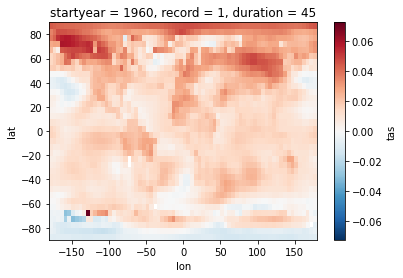

In [96]:
out.sel(duration=45,record=1).plot()

#### GISTEMP_5x5

In [10]:
%%time
save_path = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5/'

# Set File list
data_paths = gistemp_5x5_files
data_paths = data_paths # consider those already processed

# Set var
var_gistemp = 'tempAnom'
# var = 'tempAnom'
var = 'tas'

# Set startyears and durations
startyears = [1960]
_startyear = 1960
durations = np.arange(2,61) # Only goes through 2020

gistemp_new_times = (pd.date_range("1960-01-01", freq="1M", periods=12*61)-pd.offsets.MonthBegin(1)).shift(periods=14,freq='D')

record_list = []
for _data_path in data_paths:
    
    filename = _data_path.split('/')[-1][:-3]
    
    output_string = '%s/%s.5x5degSpatialTrends.196001-202012.nc' % (save_path,filename)
    
    i = _data_path.split('_')[-1][:3]
    print(i)
    
    data = xr.open_dataset(_data_path,chunks={'time': -1})[var_gistemp]

    data = gistemp_5x5_tselect(data) # Select post 1960 period

    data_ann = data.groupby('time_2').mean(dim='time_2').rename({'time_2':'year','time':'record'})
    data_ann['record'] = 2*int(i) + np.arange(1,2.1,1) # New data only has 2 records per file?
    # data_ann['record'] = 10*int(i) + np.arange(1,10.1,1)    
    
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    while len(_startyear_str) < 4: # pad with zeros
        _startyear_str = '0' + _startyear_str
    
    data_ann_slice = data_ann.sel(year=slice(_startyear,_startyear+durations[-1]))
    
    slopes_by_dur = []
    
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    slopes_by_dur.append(dask.delayed(calc_trends_noload)(data=data_ann_slice,
                                                          var=var,
                                                          startyear=_startyear_str,
                                                          endyears=_endyears,
                                                          wrapper_func=gettrends_wrapper2,
                                                          calc_slopes_func=calc_slopes_spatial_ann2,
                                                          ))
    try:
        slopes_by_dur_computed = dask.compute(*slopes_by_dur)
        slopes_by_dur_computed[0].to_netcdf(output_string)
        print(output_string)
    except ValueError:
        print('ValueError for %s' % filename)
        print('var: ',var)
        print('startyear: ',_startyear_str)
        print('endyears: ',_endyears)
        break
    

001


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_001.5x5degSpatialTrends.196001-202012.nc
002


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_002.5x5degSpatialTrends.196001-202012.nc
003


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_003.5x5degSpatialTrends.196001-202012.nc
004


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_004.5x5degSpatialTrends.196001-202012.nc
005


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_005.5x5degSpatialTrends.196001-202012.nc
006


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_006.5x5degSpatialTrends.196001-202012.nc
007


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_007.5x5degSpatialTrends.196001-202012.nc
008


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_008.5x5degSpatialTrends.196001-202012.nc
009


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_009.5x5degSpatialTrends.196001-202012.nc
010


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_010.5x5degSpatialTrends.196001-202012.nc
011


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_011.5x5degSpatialTrends.196001-202012.nc
012


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_012.5x5degSpatialTrends.196001-202012.nc
013


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_013.5x5degSpatialTrends.196001-202012.nc
014


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_014.5x5degSpatialTrends.196001-202012.nc
015


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_015.5x5degSpatialTrends.196001-202012.nc
016


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_016.5x5degSpatialTrends.196001-202012.nc
017


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_017.5x5degSpatialTrends.196001-202012.nc
018


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_018.5x5degSpatialTrends.196001-202012.nc
019


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_019.5x5degSpatialTrends.196001-202012.nc
020


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_020.5x5degSpatialTrends.196001-202012.nc
021


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_021.5x5degSpatialTrends.196001-202012.nc
022


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/GISTEMP_5x5//ensembleChunk_5x5_022.5x5degSpatialTrends.196001-202012.nc
CPU times: user 21.6 s, sys: 964 ms, total: 22.6 s
Wall time: 26.7 s


#### HadCrut5

In [9]:
save_path = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5/'


In [10]:
test_ds = xr.open_dataset('%s/HadCRUT.5.0.1.0.analysis.anomalies.39.nc' % (save_path))

In [12]:
test_ds['tas']

<xarray.DataArray 'tas' (realization: 1, time: 756, RegionIndex: 58)>
array([[[ 2.025099, -0.656034, ..., -0.338793, -0.433678],
        [ 0.130127,  2.011232, ..., -0.43788 , -0.530713],
        ...,
        [ 2.335976,  1.777205, ...,  0.368178,  0.415087],
        [ 1.631569,  0.527166, ...,  0.394958,  0.577558]]])
Coordinates:
  * realization   (realization) int64 39
  * time          (time) datetime64[ns] 1960-01-16T12:00:00 ... 2022-12-16T12...
  * RegionIndex   (RegionIndex) int64 0 1 2 3 4 5 6 7 ... 51 52 53 54 55 56 57
    RegionAbbrev  (RegionIndex) object 'GIC' 'NWN' 'NEN' ... 'EIO' 'SIO' 'SOO'
    RegionName    (RegionIndex) object 'Greenland/Iceland' ... 'Southern-Ocean'

In [ ]:
%%time
save_path = '/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5/'

# Set File list
data_paths = hadcrut5_files

# Set var
var_gistemp = 'tempAnom'
var = 'tas'

# Set startyears and durations
startyears = [1960]
_startyear = 1960
durations = np.arange(2,61) # Only goes through 2020

# gistemp_new_times = (pd.date_range("1960-01-01", freq="1M", periods=12*61)-pd.offsets.MonthBegin(1)).shift(periods=14,freq='D')

record_list = []
for _data_path in data_paths:
    
    i = _data_path.split('_')[-1][:3]
    # print(i)
    
    data = xr.open_dataset(_data_path,chunks={'time': -1})[var]

    data = data.sel(time=slice('1960-01-01',None)) # Select post 1960 period

    data_ann = data.groupby('time.year').mean(dim='time')
    # data_ann = data.groupby('time_2').mean(dim='time_2').rename({'time_2':'year','time':'record'})
    # data_ann['record'] = 10*int(i) + np.arange(1,10.1,1)    
    
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    while len(_startyear_str) < 4: # pad with zeros
        _startyear_str = '0' + _startyear_str
    
    data_ann_slice = data_ann.sel(year=slice(_startyear,_startyear+durations[-1]))
    
    slopes_by_dur = []
    
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    slopes_by_dur.append(dask.delayed(calc_trends_noload)(data=data_ann_slice,
                                                          var=var,
                                                          startyear=_startyear_str,
                                                          endyears=_endyears,
                                                          wrapper_func=gettrends_wrapper2,
                                                          calc_slopes_func=calc_slopes_spatial_ann2,
                                                          ))
    
    slopes_by_dur_computed = dask.compute(*slopes_by_dur)
    
    filename = _data_path.split('/')[-1][:-3]
    
    output_string = '%s/%s.5x5degSpatialTrends.196001-202012.nc' % (save_path,filename)
    print(output_string)
    
    slopes_by_dur_computed_final = slopes_by_dur_computed[0].assign_coords({'realization':data.realization}).expand_dims('realization',axis=-1)    
    
    slopes_by_dur_computed_final.to_netcdf(output_string)

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.1.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.10.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.100.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.101.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.102.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.103.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.104.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.105.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.106.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.107.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.108.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.109.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.11.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.110.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.111.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.112.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.113.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.114.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.115.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.116.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.117.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.118.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.119.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.12.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.120.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.121.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.122.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.123.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.124.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.125.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.126.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.127.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.128.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.129.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.13.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.130.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.131.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.132.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.133.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.134.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.135.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.136.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.137.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.138.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.139.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.14.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.140.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.141.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.142.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.143.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.144.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.145.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.146.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.147.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.148.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.149.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.15.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.150.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.151.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.152.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.153.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.154.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.155.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.156.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.157.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.158.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.159.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.16.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.160.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.161.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.162.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.163.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.164.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.165.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.166.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.167.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.168.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.169.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.17.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.170.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.171.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.172.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.173.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.174.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.175.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.176.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.177.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.178.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.179.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.18.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.180.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.181.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.182.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.183.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.184.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.185.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.186.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.187.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.188.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.189.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.19.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.190.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.191.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.192.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.193.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.194.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.195.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.196.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.197.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.198.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.199.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.2.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.20.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.200.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.21.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.22.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.23.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.24.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.25.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.26.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.27.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.28.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.29.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.3.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.30.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.31.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.32.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.33.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.34.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.35.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.36.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.37.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.38.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.39.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.4.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.40.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.41.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.42.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.43.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.44.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.45.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.46.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.47.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.48.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.49.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.5.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.50.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.51.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.52.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.53.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.54.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.55.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.56.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.57.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.58.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.59.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.6.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.60.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.61.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.62.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.63.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.64.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.65.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.66.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.67.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.68.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.69.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.7.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.70.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.71.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.72.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.73.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.74.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.75.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.76.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.77.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.78.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.79.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.8.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.80.5x5degSpatialTrends.196001-202012.nc


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/HadCRUT5//HadCRUT.5.0.1.0.analysis.anomalies.81.5x5degSpatialTrends.196001-202012.nc
